### Вводные
Заказчик в лице ML-отдела планирует выкатывать новый алгоритм, рекомендующий нашим пользователям интересные посты. После обсуждений того, как он это делает, вы пришли к следующему пониманию:

* Алгоритм добавляет пользователям 1-2 просмотра
* Вероятность того, что он сработает, составляет 90%
* Если у пользователя меньше 50 просмотров, то алгоритм не сработает
* На эксперимент выделена 1 неделя

Предпологая, что увеличение числа просмотров приведёт и к увеличению лайков на пользователя, возможно ли обнаружить различия в среднем количестве лайков на пользователя? 

### Ход действий
* Распределения, из которых мы будем симулировать просмотры и пользовательские CTR, мы построим на основе периода 2024-02-23 - 2024-02-29 (в этот период проводился АА-тест). 
* На эксперимент нам выделили неделю. Предоположим, за эту неделю в сервис зайдёт столько же пользователей, сколько зашло в указанный период. 
* Разбивка пользователей будет проводиться на две группы в соотношении 50/50.
* Эффект алгоритма на просмотры сымитируем.
* Лайки мы буду сравнивать t-тестом с поправкой Уэлча на неравные дисперсии (equal_var=False). Уровень значимости задам 0.05.

In [26]:
# Подключаю нужные пакеты
import configparser

import pandahouse
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

#Генератор псевдослучайных чисел. Использую Numpy, т.к. он генерирует быстрее чем Scipy
rng = np.random.default_rng()

In [15]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [16]:
# Подсоединяемся к нужной базе данных.
# Логины, пароли и прочее в отдельном файле
connection = {
    'host': config.get('clickhouse_connection', 'host'),
    'user': config.get('clickhouse_connection', 'user'),
    'password': config.get('clickhouse_connection', 'password'),
    'database': config.get('clickhouse_connection', 'database')
}

Посмотрю данные по просмотрам и CTR за период АА-теста и подготовлю их нужным образом.

In [17]:
#эмпирическое распределение просмотров

q = """
select views, count() as users
from (select  
    user_id,
    sum(action = 'view') as views
from simulator_20240320.feed_actions
where toDate(time) between '2024-02-23' and '2024-02-29'
group by user_id
)
group by views
order by views
"""


views_distribution = pandahouse.read_clickhouse(q, connection=connection)
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
views_distribution.head()

,views,users,p
0,1,4,0.000095
1,2,1,0.000024
2,3,4,0.000095
3,4,5,0.000119
4,5,18,0.000429


In [18]:
#CTR (оставлю группировку по дате для большего разнообразия в CTR)
q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20240320.feed_actions
where dt between '2024-02-23' and '2024-02-29'
group by dt, user_id
)
group by ctr
"""

#эмпирическое распределение
ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.head()

,ctr,users,p
0,0.00,1443,0.016952
1,0.65,4,0.000047
2,0.71,5,0.000059
3,0.49,4,0.000047
4,0.54,72,0.000846


##### Количество пользователей в период АА-теста

In [19]:
#сколько пользователей было в АА-тесте
q = """
select uniqExact(user_id)
from simulator_20240320.feed_actions
where toDate(time) between '2024-02-23' and '2024-02-29'

"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,41997


Посмотрю, сколько отойдет каждой группе. Уже сразу видно, что это будет дробное число - округлю. 

In [6]:
#сколько попадёт в одну группу при равной разбивке
np.floor(41997 / 2)

20998.0

#### Генерация данных на основе реальных
Посмотрю на распределения, которые генерирую на основе реальных данных. 

<b>Просмотры</b>. Видна явная асимметрия, можно заметить небольшую двухгорбость.

<Axes: ylabel='Count'>

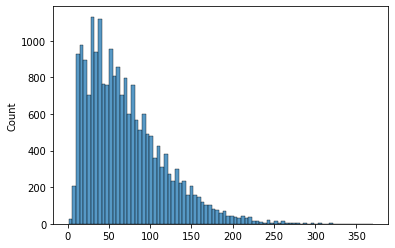

In [7]:
sim_views = rng.choice(a=views_distribution.views, size=20998, replace=True, p=views_distribution.p)
sns.histplot(sim_views)

CTR выглядят разреженными, чего стоило ожидать - ведь округлили непрерывную величину и сэмплировали эти округлённые значения, а любые промежуточные значения генерироваться не будут. 

Этот подход грубоват но для текущих целей подойдёт такое приближение.

<Axes: ylabel='Count'>

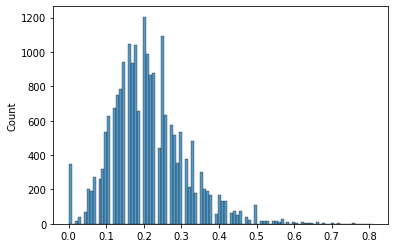

In [20]:
sim_ctrs = rng.choice(a=ctr_distribution.ctr, size=20998, replace=True, p=ctr_distribution.p)
sns.histplot(sim_ctrs)

 <b>Лайки/клики</b>. В целом распределение похоже на распределение просмотров, но выглядит ещё более асимметричным.

<Axes: ylabel='Count'>

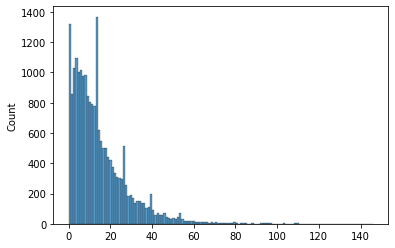

In [9]:
sim_clicks = rng.binomial(n=sim_views.astype("int64"), p=sim_ctrs)
sns.histplot(sim_clicks)

Прежде чем я начну симулировать АБ-тестирование и считать мощности, неплохо будет сделать искусственный АА-тест и убедиться что доля ложноположительных результатов (False Positive Rate, FPR) примерно равно значению альфа (0.05).

In [10]:
#функция для расчёта FPR

def fpr_calc(sample_size, views_df, ctr_df, nsim=1000):
    """
    Считает FPR для t-теста при заданных параметрах распределения
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляция и сравнение выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулирую просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулирую CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулирую лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваю t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаю FPR
    return np.mean(np.array(pvalues) < 0.05)

Результат довольно близок к ожидаемому: повторная симуляция будет давать другие значения, но "вращаться" они будут около 0.05.<br>
P.S. Если хочется еще точнее приблизиться, можно увеличить количество симуляций nsim.

In [11]:
fpr_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, nsim=20000)

100%|██████████| 20000/20000 [04:36<00:00, 72.27it/s]


0.04775

#### Расчет
##### Увеличение числа просмотров на 1-2 с 90%-ой вероятностью для пользователей с числом просмотров более 50

Реализовывать эффект буду созданием последовательности из 1 и 2, в соотношении примерно 50/50, фактически генерируя 0 и 1 с вероятностью в 50%, а потом добавляя к ним всем 1.

In [21]:
1 + rng.binomial(n=1, p=0.5, size=20998)

array([2, 2, 1, ..., 2, 1, 1])

Таким способом я создаю "маску" из 0 и 1 - то, есть для тех на ком алгоритм сработал или нет. Так как вероятность 90%, большая часть значений будет "1".

In [13]:
rng.binomial(n=1, p=0.9, size=20998)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

Последняя "маска" - пользователи с числом просмотров большим либо равным 50. 

In [22]:
sim_views >= 50

array([ True, False, False, ...,  True, False, False])

Когда мы всё это перемножу, получу массив из 0, 1, 2, где:

* 0 - это пользователи, для которых алгоритм не сработал по одной из двух причин. Либо у него просмтров мало, либо ему просто не повезло и он попал в 10%, либо все сразу.
* 1 - один просмотр
* 2 - два просмотра

In [23]:
rng.binomial(n=1, p=0.9, size=20998) * (1 + rng.binomial(n=1, p=0.5, size=20998)) * (sim_views >= 50)

array([1, 0, 0, ..., 2, 0, 0])

Складываю результат сложения массивов к просмотрам и получаю искомый <b>эффект</b>. На основе этого буду генерировать лайки, которые меня и интересуют.

In [24]:
sim_views + (rng.binomial(n=1, p=0.9, size=20998) * (1 + rng.binomial(n=1, p=0.5, size=20998)) * (sim_views >= 50))

array([65., 34., 34., ..., 89., 33., 23.])

#### Считаю мощность

In [25]:
def power_calc(sample_size, views_df, ctr_df, threshold, nsim=1000):
    """
    Считает мощность для t-теста при заданных параметрах распределения и эффекта
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param threshold: порог просмотров, после которого начинает действовать алгоритм
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда складываются p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляция и сравнение выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулирую просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулирую эффект в тестовой группе
        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #симулирую CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулирую лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваю t-тестом и сохраняю p-value
        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаю искомую мощность
    return np.mean(np.array(pvalues) < 0.05)

In [19]:
power_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, threshold=50, nsim=20000)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:21<00:00, 99.09it/s]


0.25395

### Выводы
Искомая мощность составила 25.3 % - Это очень мало. В текущей конфигурации требуемой мощности в 80% не добиться.

Можно попробовать поиграться с гипотетическими начальными данными, например:
* Алгоритм не сработает, если у пользователя меньше 30 просмотров (было 50)
* Увеличить длительность эксперимента на 2 недели
* Учитывать пользователей только с не менее 30 просмотрами

#### Расчет
##### Увеличение числа просмотров на 1-2 с 90%-ой вероятностью для пользователей с числом просмотров более 30

In [27]:
power_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [04:51<00:00, 68.70it/s]


0.41475

#### Промежуточные выводы
Теперь мощность около 41% - то есть дополнительно получили 16% мощности. Это всё ещё очень мало.

#### Расчет
##### Увеличение продолжительности эксперимента до 2-х недель

In [28]:
q = """
select uniqExact(user_id)
from simulator_20240320.feed_actions
where toDate(time) between '2024-02-23' and '2024-03-07'

"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,61182


In [30]:
np.floor(61182 / 2)

30591.0

In [31]:
power_calc(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [06:52<00:00, 48.49it/s]


0.55585

#### Промежуточные выводы
Мощность где-то около 55.5%. Лучше, но до порога в 80% ещё 24%.

#### Расчет
##### Учет только пользователей с числом просмотров  не менее 30

In [32]:
def power_calc_masked(sample_size, views_df, ctr_df, threshold, nsim=1000):
    """
    Считает мощность для t-теста при заданных параметрах распределения и эффекта + отсекает пользователей ниже нужного порога
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param threshold: порог просмотров, после которого начинает действовать алгоритм
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляция и сравнение выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулиру/ просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулирую эффект в тестовой группе
        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #маска для отсеивания лишних пользователей
        mask_A = group_A_views>=threshold
        mask_B = group_B_views>=threshold

        #симулирую CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулирую лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваю t-тестом и сохраняю p-value
        pvalues.append(ttest_ind(clicks_A[mask_A], clicks_B[mask_B], equal_var=False).pvalue)

    #возвращаю мощность
    return np.mean(np.array(pvalues) < 0.05)

In [33]:
power_calc_masked(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [07:03<00:00, 47.18it/s]


0.6451

#### Промежуточные выводы
Получаю где-то 64.5% -  все еще недостаточно...

### Общие выводы и рекомендации

Несмотря на все усилия, добраться до уровня мощности в 80% так и не получилось. Что в таком случае можно предпринять?

* Отказаться от идеи эксперимента вообще. Раз не хватает ресурсов для детекции такого изменения, то и смысла особо действовать нет.
* Всё равно запустить эксперимент и надеяться на лучшее. Платой за это решение будет меньшая уверенность в полученных результатах.
* Дорабатывать алгоритм, чтобы его эффект либо распространялся на большее число пользователей, либо чтобы он был больше.
* Понижать дисперсию метрики методами стратификации либо CUPED.
* Посмотреть на актуальное количество уникальных пользователей в сервисе. Если был положительный тренд - возможно, на текущий момент можно позволить себе гораздо больше пользователей.
* Поменять уровень значимости на более высокий. Платой за это будет большая вероятность ложноположительного результата.
* Поменять статистический тест на другой; может, t-тест просто имеет тут недостаточно мощности. Возможно, также поможет линеаризация или какой-нибудь вариант бакетизации.